**Problem Statement : **To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.



The data set contains the following diseases:




*   Actinic keratosis
*   Basal cell carcinoma
*   Dermatofibroma
*   Melanoma
*   Nevus
*   Pigmented benign keratosis
*   Seborrheic keratosis
*   Squamous cell carcinoma
*   Vascular lesion







In [ ]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical 
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
# Data mounting the google drive, using the following :

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Drawing out the data to train and test images
root_path = '/content/gdrive/MyDrive/Skin cancer'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [ ]:
#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


# Load using keras.preprocessing

Let's load these images off disk using image_dataset_from_directory utility.

# Create a dataset



In [ ]:
# Define some parameters for the loader:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
#Visualize one instance of all the class present in the dataset.
#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Lets do for Validation set now
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
## Lets do for test set to visualise the class present

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size )

Found 118 files belonging to 9 classes.


In [ ]:
# Lets find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


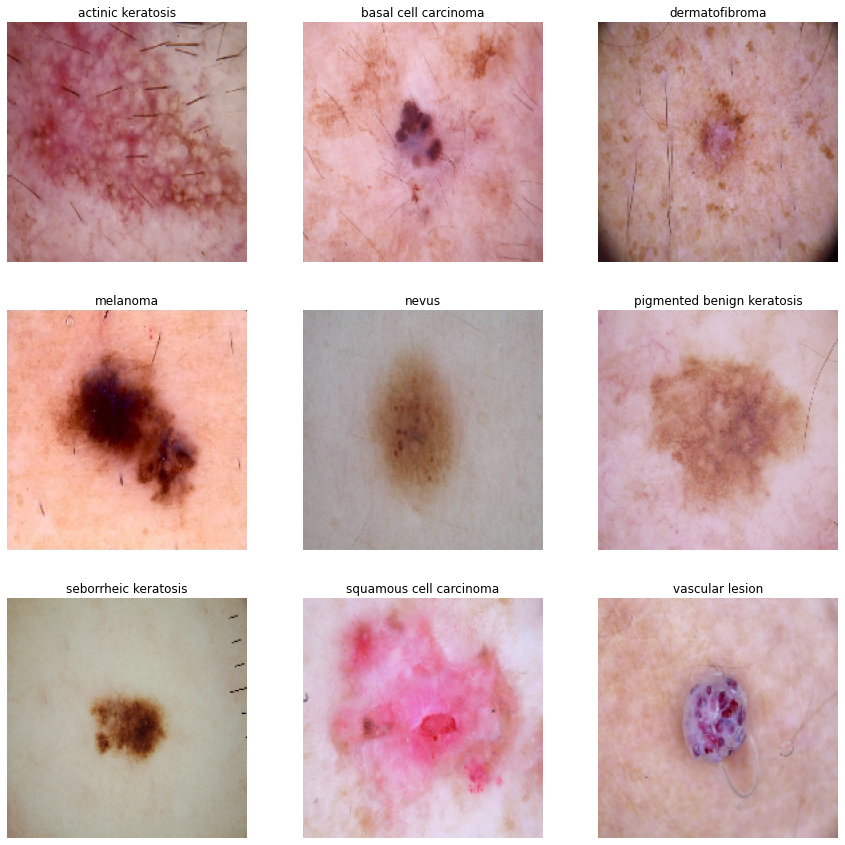

In [ ]:
#Dictionary to store the path of image as per the class
#a code to visualize one instance of all the nine classes present in the dataset

files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

**Dataset.cache()** keeps the images in memory after they're loaded off disk during the first epoch.

**Dataset.prefetch()** overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)




 Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]




In [ ]:
# Standardizing values in [0,1]
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
category_layer = tf.keras.layers.experimental.preprocessing.CategoryEncoding(num_tokens=9, output_mode="one_hot")

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), category_layer(y)))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), category_layer(y)))

# Create the model



In [ ]:
#CNN base Model Architecture
input_shape = (180,180,3)

#Sequential allows us to create models layer-by-layer  
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

#First Convulation layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Second Convulation layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Flatten Layer
model.add(Flatten())

#Dense Layer
model.add(Dense(512, activation='relu'))

model.add(Activation('relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(Dense(9))
model.add(Activation('softmax'))

## Number of classes is 9
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 41, 41, 64)        3

## Compile the model



In [ ]:
### choose an appropirate optimiser and loss function 
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# modal compiled

## Train the model

In [ ]:
# train with epochs = 20
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 666s 2s/step - loss: 2.0543 - accuracy: 0.2238 - val_loss: 1.8997 - val_accuracy: 0.3110
Epoch 2/20
56/56 [==============================] - 4s 62ms/step - loss: 1.8499 - accuracy: 0.3131 - val_loss: 1.7244 - val_accuracy: 0.3579
Epoch 3/20
56/56 [==============================] - 3s 61ms/step - loss: 1.7860 - accuracy: 0.3426 - val_loss: 1.6861 - val_accuracy: 0.3490
Epoch 4/20
56/56 [==============================] - 3s 61ms/step - loss: 1.6035 - accuracy: 0.4141 - val_loss: 1.6097 - val_accuracy: 0.4676
Epoch 5/20
56/56 [==============================] - 3s 61ms/step - loss: 1.4837 - accuracy: 0.4743 - val_loss: 1.4492 - val_accuracy: 0.4698
Epoch 6/20
56/56 [==============================] - 3s 61ms/step - loss: 1.4111 - accuracy: 0.5017 - val_loss: 1.4412 - val_accuracy: 0.4609
Epoch 7/20
56/56 [==============================] - 3s 61ms/step - loss: 1.2766 - accuracy: 0.5402 - val_loss: 1.3998 - val_accuracy: 0.4922
Epoch 8/20
56

In [ ]:
# Visualizing training results

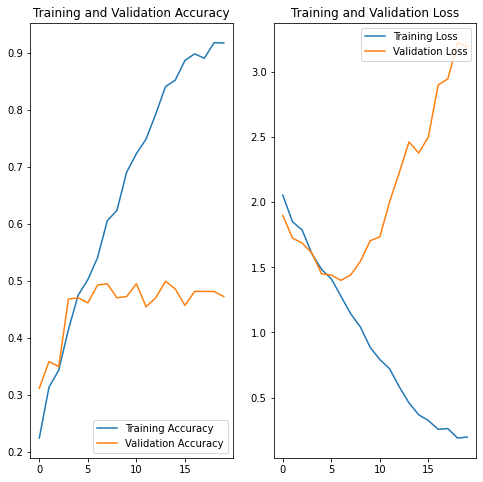

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 22ms/step - loss: 3.1930 - accuracy: 0.4720
Accuracy:  0.9453125
Validation Accuracy:  0.47203579545021057
Loss:  0.1235726848244667
Validation Loss 3.193006992340088


As we observed the model is overfitting, we can say this per below findings:

* After 20 epochs, The training accuracy ~ 91% but on the other hand validation accuracy is around 49.21%.
* With each epoch the validation loss is increasing and training loss is decreasing.

In [ ]:
# Augmenting images by rotating, flipping, zooming, shearing, height-width shifting, and fill mode to be nearest 
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range            = 90.0,
    zoom_range                = [0.9,1.1],
    horizontal_flip           = [0.9,1.1],
    vertical_flip             = True,
    height_shift_range        = 10.0,
    width_shift_range         = 10.0,
    shear_range               = 5.0,
    channel_shift_range       = 0.0,
    brightness_range          = None,
    fill_mode                 = 'nearest',     
    validation_split          =0.2                     
    )
                                  

# Train data
train_generator = train_datagen.flow_from_directory(data_dir_train,
                                                    subset='training',                  
                                                    target_size=(180, 180),
                                                    batch_size = 32,
                                                    class_mode='categorical',
                                                    )

# Validation data
valid_generator = train_datagen.flow_from_directory(data_dir_train,
                                                    subset='validation',                 
                                                    target_size=(180, 180),
                                                    batch_size = 32,
                                                    class_mode='categorical',
                                                    )

Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


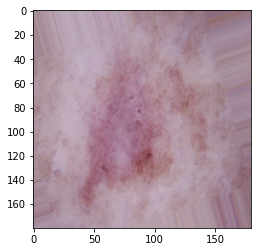

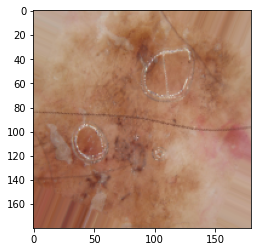

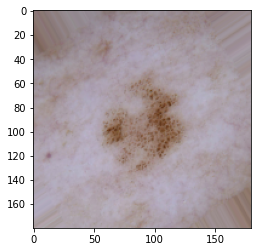

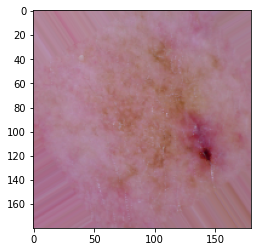

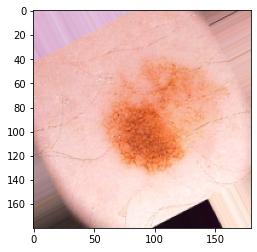

In [ ]:
# Visualizing how augmentation strategy works for some training images
# Your code goes here
x_batch, y_batch = next(train_generator)

for i in range (0,5):
    image = x_batch[i]
    plt.imshow(image)
    plt.show()

## Create, compile and train the model



In [ ]:
## We can use Dropout layer if there is an evidence of overfitting in our findings

model2 = Sequential()
#First Convulation layer
model2.add(Conv2D(32, (3, 3), input_shape=(180, 180, 3), activation='relu'))
model2.add(Activation('relu'))
#Second Convulation layer
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
# Max Pool size of 2*2
model2.add(MaxPooling2D(pool_size=(2, 2)))

#Third Convulation layer
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
#Fourth Convulation layer
model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
# Max Pool size of 2*2
model2.add(MaxPooling2D(pool_size=(2, 2)))
#Dropout layer with 15% Fraction of the input units to drop.
model2.add(Dropout(0.15))

#Fifth Convulation layer
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
#Sixth Convulation layer
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
# Max Pool size of 2*2
model2.add(MaxPooling2D(pool_size=(2, 2)))

#Flatten Layer
model2.add(Flatten())
#Dense Layer
model2.add(Dense(512))
model2.add(Activation('relu'))
#Dense Layer
model2.add(Dense(128))
model2.add(Activation('relu'))
#Dropout layer with 15% Fraction of the input units to drop.

model2.add(Dropout(0.15))
model2.add(Dense(9))
model2.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 41, 41, 64)        3

**Compiling the model**



In [ ]:
### choose an appropirate optimiser and loss function for second model
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
## training second model for 20 epochs
epochs = 20
model2_history = model2.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  workers=12
)

Epoch 1/20
57/57 [==============================] - 513s 9s/step - loss: 2.0669 - accuracy: 0.1811 - val_loss: 2.0278 - val_accuracy: 0.2072
Epoch 2/20
57/57 [==============================] - 507s 9s/step - loss: 2.0317 - accuracy: 0.2017 - val_loss: 2.0212 - val_accuracy: 0.1959
Epoch 3/20
57/57 [==============================] - 505s 9s/step - loss: 2.0336 - accuracy: 0.1861 - val_loss: 2.0185 - val_accuracy: 0.2072
Epoch 4/20
57/57 [==============================] - 503s 9s/step - loss: 2.0313 - accuracy: 0.1961 - val_loss: 2.0297 - val_accuracy: 0.2072
Epoch 5/20
57/57 [==============================] - 508s 9s/step - loss: 2.2155 - accuracy: 0.1961 - val_loss: 2.0451 - val_accuracy: 0.1757
Epoch 6/20
57/57 [==============================] - 545s 9s/step - loss: 2.0628 - accuracy: 0.1916 - val_loss: 2.0142 - val_accuracy: 0.1689
Epoch 7/20
56/57 [============================>.] - ETA: 7s - loss: 2.0288 - accuracy: 0.1951 

<built-in method keys of dict object at 0x7f4827649500> :


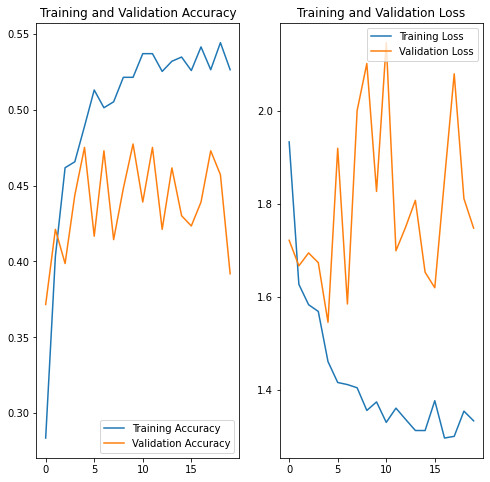

In [29]:
acc = model2_history.history['accuracy']
print(model2_history.history.keys, ":")
val_acc = model2_history.history['val_accuracy']

loss = model2_history.history['loss']
val_loss = model2_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

* We can observe clearly this is a clear case of Underfitting. We reach to this conclusion be observiinig below findings
* Training and Validation accuracy are closely following each other. However, both are aroound 50%
* Both the losses are less.
* By Augmentation, overfitting can be handled

Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Found 2239 files belonging to 9 classes.


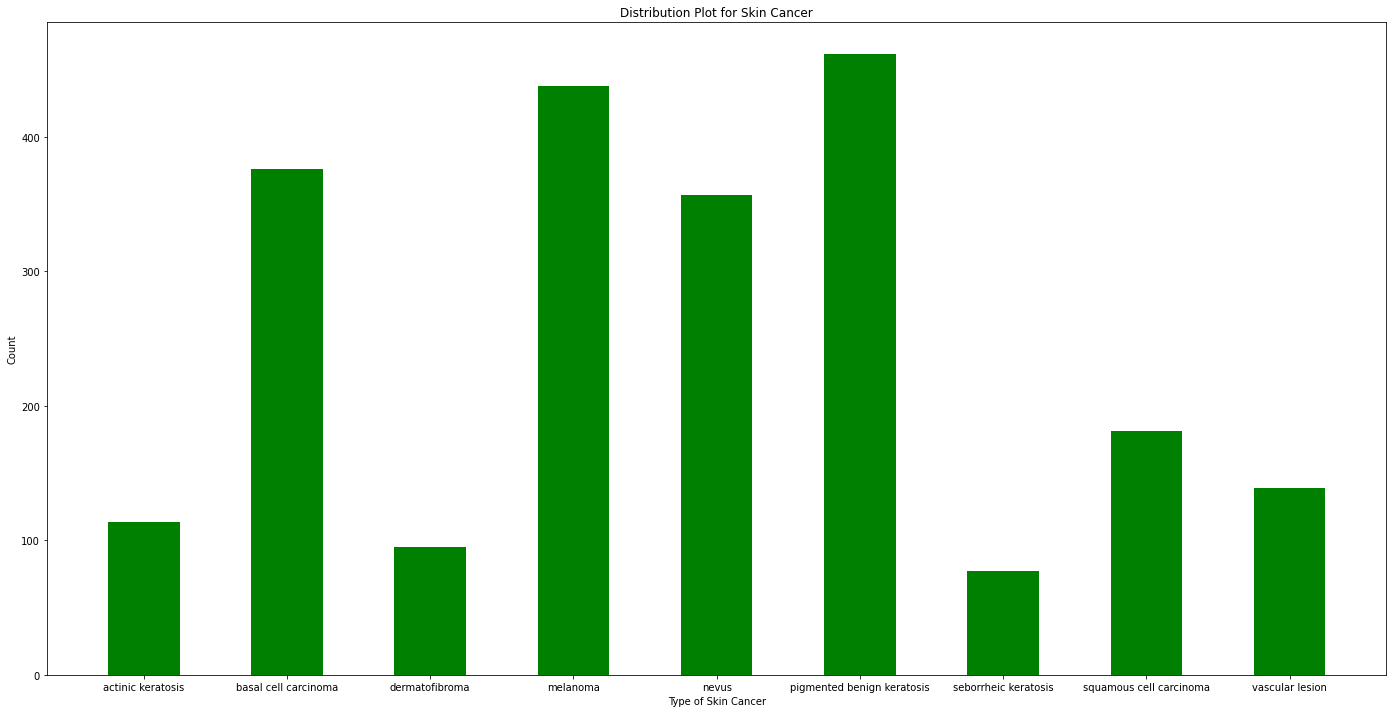

In [30]:
# visualize how your augmentation strategy works for one instance of training image.
# reading the entire training dataset 
# Checking distribution of classes in the training dataset.
import tensorflow_datasets as tfds

train_ds_plot = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
    )

train_ds_plot = train_ds_plot.map(lambda x, y: (normalization_layer(x), category_layer(y)))

# converting to numpy array
train_np = tfds.as_numpy(train_ds_plot)

distribution = []

# creating a dictionary obj to calculate the count of each skin cancer type
class_dist = dict()
for features_labels in train_np:
    for row in features_labels[1]:
        distribution.append(row)

dist_df = pd.DataFrame(distribution)   
dist_df.columns = class_names

# calculating count of eachtype
for cls in class_names:
    class_dist[cls] = dist_df[cls].sum()
    
keys = list(class_dist.keys())
values = list(class_dist.values())
  
# plotting distribution
fig = plt.figure(figsize = (24, 12)) 
plt.bar(keys, values, color ='green', width = 0.5) 
plt.xlabel("Type of Skin Cancer")
plt.ylabel("Count")
plt.title("Distribution Plot for Skin Cancer")
plt.show()

Rectify the class imbalance Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.


* Which class has the least number of samples? - Seborrheic keratosis
* Which classes dominate the data in terms proportionate number of samples?
* pigmented benign keratosis dominates the data of count more than 100 in training

In [31]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**To use Augmentor, the following general procedure is followed:**



* Instantiate a Pipeline object pointing to a directory containing your initial image data set.
* Define a number of operations to perform on this data set using your Pipeline object.
* Execute these operations by calling the Pipeline’s sample() method.

In [32]:
path_to_training_dataset="/content/gdrive/MyDrive/Skin cancer/Train/"

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4827636A90>: 100%|██████████| 500/500 [00:22<00:00, 21.91 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F48291DF7D0>: 100%|██████████| 500/500 [00:19<00:00, 26.01 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F48291A3F50>: 100%|██████████| 500/500 [00:18<00:00, 26.84 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F483E0ECA10>: 100%|██████████| 500/500 [01:36<00:00,  5.19 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x1129 at 0x7F48276FF210>: 100%|██████████| 500/500 [01:24<00:00,  5.91 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F483E0ECA10>: 100%|██████████| 500/500 [00:18<00:00, 26.66 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F48B00D6ED0>: 100%|██████████| 500/500 [00:44<00:00, 11.33 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F48B99C1D10>: 100%|██████████| 500/500 [00:18<00:00, 27.34 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F493979CED0>: 100%|██████████| 500/500 [00:17<00:00, 27.97 Samples/s]


In [33]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [34]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Skin cancer/Train/vascular lesion/output/vascular lesion_original_ISIC_0032692.jpg_f5af1373-6052-4c44-9c21-cd865e91476a.jpg',
 '/content/gdrive/MyDrive/Skin cancer/Train/vascular lesion/output/vascular lesion_original_ISIC_0027563.jpg_af5db0b7-97db-42c5-a06f-82c805393e9b.jpg',
 '/content/gdrive/MyDrive/Skin cancer/Train/vascular lesion/output/vascular lesion_original_ISIC_0032057.jpg_3587b8e6-4d37-4e59-a79c-b6ab56595d32.jpg',
 '/content/gdrive/MyDrive/Skin cancer/Train/vascular lesion/output/vascular lesion_original_ISIC_0025707.jpg_5a7014a8-2214-467f-8dab-833bfb848bde.jpg',
 '/content/gdrive/MyDrive/Skin cancer/Train/vascular lesion/output/vascular lesion_original_ISIC_0025680.jpg_fdd8446f-412d-4e6d-95d7-e71272861155.jpg',
 '/content/gdrive/MyDrive/Skin cancer/Train/vascular lesion/output/vascular lesion_original_ISIC_0025244.jpg_f1b639ac-a983-446d-9eb7-5c7fc7604f91.jpg',
 '/content/gdrive/MyDrive/Skin cancer/Train/vascular lesion/output/vascular lesion_origi

In [35]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [36]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [37]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [38]:
new_df['Label'].value_counts()


vascular lesion               500
seborrheic keratosis          500
actinic keratosis             500
basal cell carcinoma          500
melanoma                      500
pigmented benign keratosis    500
dermatofibroma                500
squamous cell carcinoma       500
nevus                         500
Name: Label, dtype: int64

Now, we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.


In [39]:
#Train the model on the data created using Augmentor

batch_size = 32
img_height = 180
img_width = 180

In [40]:
data_dir_train="/content/gdrive/MyDrive/Skin cancer/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)
# Create a training dataset

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [41]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [42]:
# Create model with normalization
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
category_layer = tf.keras.layers.experimental.preprocessing.CategoryEncoding(num_tokens=9, output_mode="one_hot")

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), category_layer(y)))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), category_layer(y)))

In [44]:
model3 = Sequential( 
    [tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)])

## simple model works better with more data

model3.add(Conv2D(16, 3, padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2))) # 

model3.add(Conv2D(32, 3, padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, 3, padding='same'))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
# Adding Dropout Layer
model3.add(Dropout(0.40))

model3.add(Flatten())
model3.add(Dense(128))
model3.add(Activation('relu'))
model3.add(Dense(9))
model3.add(Activation('softmax'))

# model3.summary()

In [45]:
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [46]:
epochs = 30

model3_history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  workers=12
  )

Epoch 1/30
169/169 [==============================] - 36s 195ms/step - loss: 2.0818 - accuracy: 0.2302 - val_loss: 1.8980 - val_accuracy: 0.2739
Epoch 2/30
169/169 [==============================] - 30s 175ms/step - loss: 1.6072 - accuracy: 0.3730 - val_loss: 1.4304 - val_accuracy: 0.4514
Epoch 3/30
169/169 [==============================] - 32s 183ms/step - loss: 1.4107 - accuracy: 0.4618 - val_loss: 1.2958 - val_accuracy: 0.5137
Epoch 4/30
169/169 [==============================] - 31s 176ms/step - loss: 1.3073 - accuracy: 0.5074 - val_loss: 1.2499 - val_accuracy: 0.5405
Epoch 5/30
169/169 [==============================] - 30s 171ms/step - loss: 1.2369 - accuracy: 0.5304 - val_loss: 1.1341 - val_accuracy: 0.5702
Epoch 6/30
169/169 [==============================] - 35s 202ms/step - loss: 1.1970 - accuracy: 0.5555 - val_loss: 1.1964 - val_accuracy: 0.5486
Epoch 7/30
169/169 [==============================] - 30s 172ms/step - loss: 1.1416 - accuracy: 0.5733 - val_loss: 1.1222 - val_ac

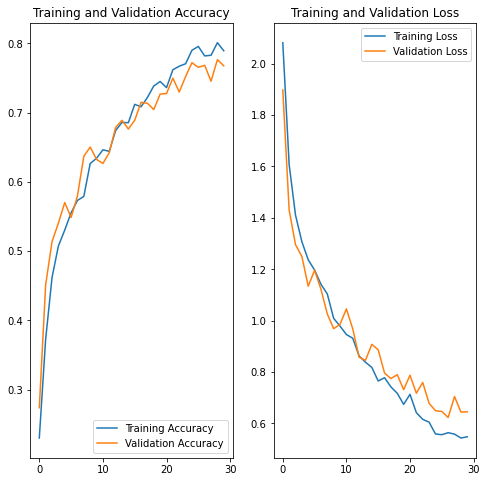

In [47]:
# Visualizing the results

acc = model3_history.history['accuracy']
val_acc = model3_history.history['val_accuracy']

loss = model3_history.history['loss']
val_loss = model3_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Did you get rid of underfitting/overfitting? Did class rebalance help?



1.   Using Augmentor library helped in reducing both overfititng as well as underfitting of the data
2.   Initially we tried without the ImageDataGenerator which created data to over fit at high ratio
3. Then we introduced dropout and ImageDataGenerator which reduced the overfit At last we tried Batch Normalization and Augumentation which looks good



In [48]:
# Observation

After 30 epochs, The third model gives us around below accuracies:



1.   Training accuracy - 78.93%
2. Validation accuracy - 76.76%



We can observe that the model is a good fit per the graph therefore both overfitting and underfitting are handled well.
